### Principal Component Regression

The SVD of the centered matrix $\mathbf{X}$ is another way of expressing the *principal components* of the variables in $\mathbf{X}$ where the sample covariance matrix is given by $\mathbf{S} = \mathbf{X}^\top\mathbf{X} / N$. Using the SVD of $\mathbf{X}$ we obtain:

$$\mathbf{X}^\top\mathbf{X} = \mathbf{V}\mathbf{D}^2\mathbf{V}^\top$$

which is the eigen decomposition of $\mathbf{X}^\top\mathbf{X}$ and of $\mathbf{S}$ up to a factor $N$.

The columns of $\mathbf{V}$ (the eigenvectors $v_j$) are also called the principal compinents directions of $\mathbf{X}$.

The first principal component direction $v_1$ has the property that $\mathbf{z}_1 = \mathbf{X}v_1 = \mathbf{u}_1 d_1$ has the largest sample variance amongs all normalized linear combinations of $\mathbf{X}$, and the last principle component direction $v_p$ has the property that $\mathbf{z}_p = \mathbf{X}v_p = \mathbf{u}_p d_p$ has the smallest sample variance amongs all normalized linear combinations of $\mathbf{X}$.

The variance of $z$ is given as:

$$\text{Var}(z_j) = \text{Var}(\mathbf{X}v_j) = \frac{d_j^2}{N}$$

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from ml_datasets.esl import ProstateCancer
from esl.utils import scale
from esl.chapter03 import kfold, LeastSquaresRegression, RidgeRegression

In [2]:
prostate_cancer = ProstateCancer(verbose=0)
df = prostate_cancer.load()

In [3]:
train_test = prostate_cancer.train_test
df_x = df[prostate_cancer.meta[:-1]]
df_y = df[prostate_cancer.meta[-1]]

x_train = scale(df_x[train_test=='T'].copy()).values
y_train =  df_y[train_test=='T'].copy().values
y_train_temp = y_train - np.mean(y_train)

In [4]:
u, d, vT = np.linalg.svd(x_train, full_matrices=False)

z_train = x_train @ vT.T

z_dict, y_dict = kfold(z_train, y_train_temp, nfold=10, seed=2)

In [9]:
num_components = z_train.shape[1]
RSS = dict()
MRSS = dict()

for k in range(num_components + 1):
    RSS_temp = []
    MRSS_temp = []
    
    for fold in z_dict.keys():
        if k == 0:
            z_train_temp = z_dict[fold]['train'].copy()
            z_train_temp = np.hstack([np.ones_like(z_train_temp[:, 0]).reshape(-1, 1), z_train_temp])
            z_val_temp = z_dict[fold]['val'].copy()
            z_val_temp = np.hstack([np.ones_like(z_val_temp[:, 0]).reshape(-1, 1), z_val_temp])
                            
            y_train_temp = y_dict[fold]['train'].copy()
#             y_train_mean = np.mean(y_train_temp)
            
#             y_train_temp = y_train_temp - y_train_mean
            y_val_temp = y_dict[fold]['val'].copy()  #  - y_train_mean
            error = (y_val_temp).T @ (y_val_temp)
            merror = error / len(y_val_temp)
            
        else:
            z_train_temp = z_dict[fold]['train'].copy()[:, :k]
            z_train_temp = np.hstack([np.ones_like(z_train_temp[:, 0]).reshape(-1, 1), z_train_temp])
            z_val_temp = z_dict[fold]['val'].copy()[:, :k]
            z_val_temp = np.hstack([np.ones_like(z_val_temp[:, 0]).reshape(-1, 1), z_val_temp])
            y_train_temp = y_dict[fold]['train'].copy()
#             y_train_mean = np.mean(y_train_temp)
            
#             y_train_temp = y_train_temp - y_train_mean
            y_val_temp = y_dict[fold]['val'].copy()  #  - y_train_mean
            
            ridgereg = RidgeRegression()
            ridgereg.fit(z_train_temp, y_train_temp, 0)
            
            error = ridgereg.RSS(z_val_temp, y_val_temp)
            merror = ridgereg.MRSS(z_val_temp, y_val_temp)

        RSS_temp.append(error)
        MRSS_temp.append(merror)
        
    RSS[k] = RSS_temp
    MRSS[k] = MRSS_temp

In [10]:
x_cv = np.array(list(RSS.keys()))

# calculate the mean of MSE from the 10-fold cross validation
y_cv_mean = np.array([np.mean(MRSS[key]) for key in MRSS.keys()])

# calculate the standard error
y_cv_std = np.array([np.std(MRSS[key]) / (10 ** 0.5) for key in MRSS.keys()])

# find the most parsimonious model
upper_bound = np.min(y_cv_mean) + y_cv_std[np.argmin(y_cv_mean)]
best_dir = np.min(np.where(y_cv_mean <= upper_bound)[0])

(Figure 3.7 - Middle Right):

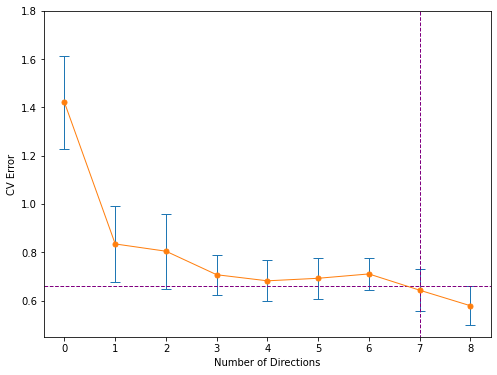

In [11]:
plt.figure(figsize=(8, 6))
plt.errorbar(x_cv, y_cv_mean, yerr=y_cv_std, capsize=5, ecolor='C0', color='C1', elinewidth=1, linewidth=1, marker='o', markersize=5)
x_cvv = np.linspace(-0.4, 8.4, 20)
y_cvv = np.linspace(0.4, 1.8, 20)

# this is to plot the purple horizontal line
plt.plot(x_cvv, upper_bound * np.ones(len(x_cvv)), '--', color='purple', linewidth=1)

# this is to plot the purple vertical line
plt.plot(best_dir * np.ones(len(y_cvv)), y_cvv, '--', color='purple', linewidth=1)

plt.xlim([-0.4, 8.4])
plt.ylim([0.45, 1.8])
plt.xlabel('Number of Directions')
plt.ylabel('CV Error')
plt.show()

In [23]:
theta = []
for i in range(z_train.shape[1]):
    theta_temp = (z_train[:, i] @ y_train) / (z_train[:, i] @ z_train[:, i])
    theta.append(theta_temp)

lsreg = LeastSquaresRegression(intercept=True)
lsreg.fit(z_train, df_y[train_test=='T'].copy().values)
beta_0 = np.mean(df_y[train_test=='T'].copy().values)
print(beta_0)
print(lsreg.beta_hat)

2.4523450850746267
[ 2.45234509  0.43526876 -0.22322851  0.3482023   0.18154434  0.07255958
 -0.18705565  0.46830738 -0.50407204]
